# Evaluation notebook

This notebook will go through different evaluations of the saved CNNs, here is the list of the CNN you can already load:
- "./saved_models/256_resnet101_pretrained.pth", a pretrained on ImageNet ResNet101 with 88% accuracy
- "./saved_models/64_resnet34_pretrained.pth", a pretrained on ImageNet ResNet34 with 84% accuracy
- "./saved_models/64_resnet34_untrained.pth", a trained from scratchs, only on the dog breed dataset, ResNet34 with 54% accuracy
- "./saved_models/128_squeezenet_pretrained.pth", a pretrained on ImageNet SqueezeNet1.1 with 65% accuracy
All of these models are in the "saved_models" folder. 

There are four parts in this notebook, each of them evaluating and displaying different results of the chosen model:
- Plots of the loss and accuracy while the model was trained
- Visualisation of test images with their scores
- Evaluation of the model on one image of your choice
- Confusion maps


In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import main
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import glob
from random import shuffle
from sklearn.metrics import confusion_matrix

# Change here the network you want to use, for better results use the BATCH_SIZE it was trained
# with
BATCH_SIZE = 256
NET = "./saved_models/256_resnet101_pretrained.pth"
use_gpu = torch.cuda.is_available()

In [16]:
# Load the test_set and test_loader, the class name and create the network for evaluation use
_, test_loader,_ , test_set = main.get_dataloader(BATCH_SIZE)
class_names = test_set.classes
class_names = [e[10:] for e in class_names]
model = main.create_model(NET, True)
model.eval()
;

model existant


''

In [17]:
# Plot the test images after they have been tansformed, removing the normalisation
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

## Evaluation of the loss and accuracy of a pretrained model
In the "saved_log" folder are all the paths to plot the training of the different models:
- './saved_log/logs_resnet101_True.npy' for the pretrained ResNet101
- './saved_log/logs_resnet34_True.npy' for the pretrained ResNet34
- './saved_log/logs_resnet34_False.npy' for the trained from scratch ResNet34
- './saved_log/logs_squeezenet_True.npy' for the pretrained SqueezeNet1.1 

The max test accuracy is: 89.17 % 
 The max train accuracy is: 81.70 % 
 the min test loss is: 0.4422 
 the min train loss is: 0.7591


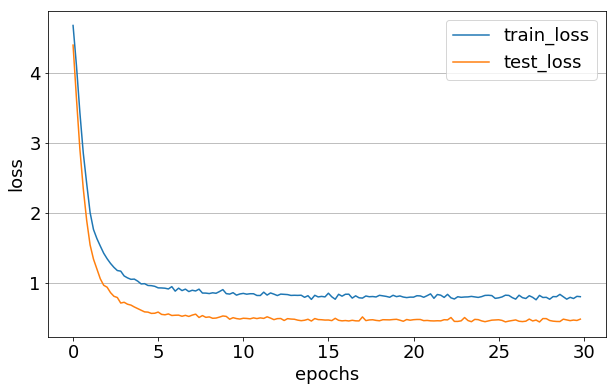

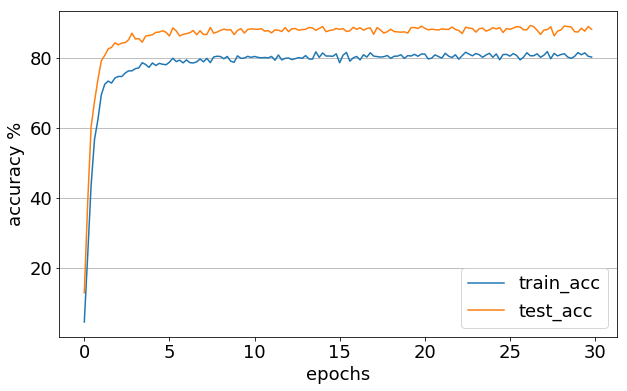

In [80]:
# Load the log file
data = np.load('./log_file/logs_resnet101_True.npy')
# Finding the max accuracies and minimum loss of the model during the training
acctest_max = np.amax(data[:,3])
acctrain_max = np.amax(data[:,2])
losstest_min = np.amin(data[:,1])
losstrain_min = np.amin(data[:,0])
print("The max test accuracy is: %.2f %% \n The max train accuracy is: %.2f %% \n the min test loss is: %.4f \n the min train loss is: %.4f"%(acctest_max, acctrain_max, losstest_min, losstrain_min))
plt.figure(figsize=(10,6))

# Plotting the loss
vec_epochs = np.arange(data.shape[0])/5
plt.plot(vec_epochs, data[:,0], label = 'train_loss')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(vec_epochs, data[:,1], label = 'test_loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10,6))
plt.grid(b=None, which='major', axis='y')
plt.xlabel('epochs')
plt.ylabel('accuracy %')
plt.plot(vec_epochs, data[:,2], label = 'train_acc')
plt.plot(vec_epochs, data[:,3], label = 'test_acc')
plt.legend()
plt.show()


## Examples of scores with predicted labels and groudtruth
In the cell below you can import a pretrained model and look how it does on a number of test images.

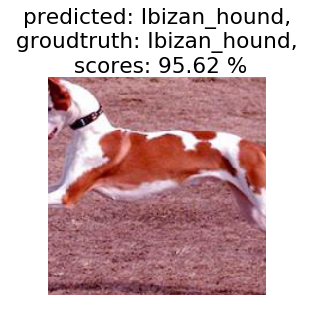

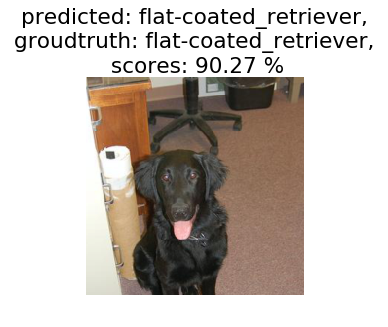

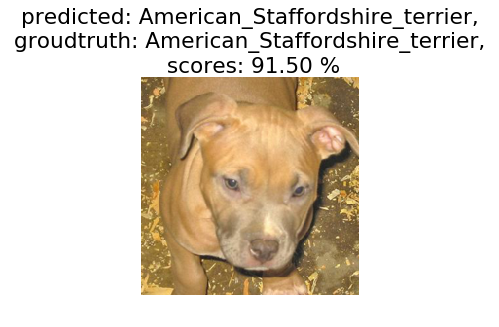

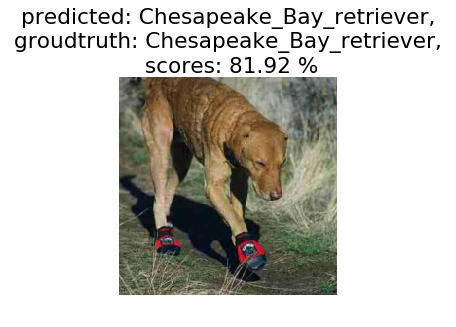

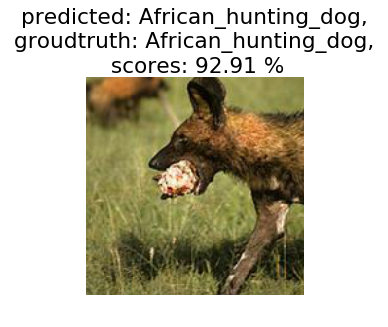

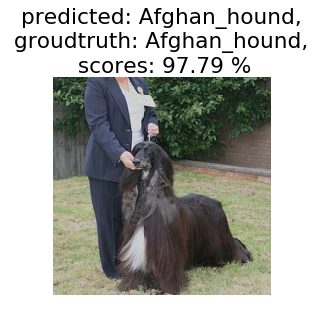

In [81]:
fig = plt.figure()
num_images = 6
plt.tight_layout()
for i, data in enumerate(test_loader):
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs = model(inputs)
    outputs = nn.functional.softmax(outputs, dim =1)
    scores, preds = torch.max(outputs.data, 1)

    labels = labels.data.cpu().numpy().tolist()
    for j in range(num_images):
        plt.axis('off')
        imshow(inputs.cpu().data[j])
        plt.title('predicted: {},\n groudtruth: {}, \n scores: {:.2f} %'.format(class_names[preds[j]], class_names[labels[j]], 100*scores[j]))
        plt.show()
    break

## Evaluation of the model on one image
In this part you can chose below to download from an URL of the image of your choice (or you can directly move it to the root directory) and then give its path to image_path in the next cell (downloaded images with wget will appear in the root directory). It will evaluate it on the model and give it its score. You can even try with a picture of you, your dog or your favorite collegue.

In [14]:
!wget https://i.imgur.com/eA7Qnso.jpg


--2018-02-05 11:17:39--  https://i.imgur.com/eA7Qnso.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.136.193
Connecting to i.imgur.com (i.imgur.com)|151.101.136.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406834 (397K) [image/jpeg]
Saving to: ‘eA7Qnso.jpg.1’

eA7Qnso.jpg.1       100%[=====================>] 397.30K  --.-KB/s   in 0.01s  

2018-02-05 11:17:39 (36.7 MB/s) - ‘eA7Qnso.jpg.1’ saved [406834/406834]



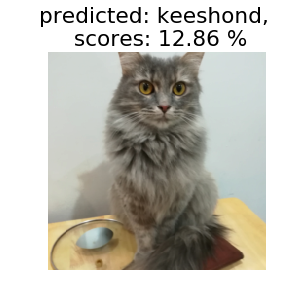

Here is a picture of the predicted dog:


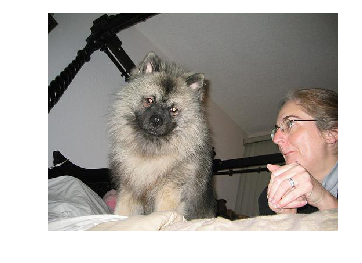

In [77]:
image_path = "./eA7Qnso.jpg"
image_PIL  = Image.open(image_path)

# Transformation of the image just like the test images
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

PIL_to_torch = transforms.ToTensor()
image = PIL_to_torch(image_PIL)

my_dog = Variable(test_transform(image_PIL).unsqueeze(0)).cuda()
outputs = model(my_dog)
outputs = nn.functional.softmax(outputs, dim=1)
scores, preds = torch.max(outputs.data, 1)
preds = preds[0]

# Getting the class labels and removing the first ten characters (ImageNet numbers)
class_names = test_set.classes
class_name_sub = class_names
class_names = [e[10:] for e in class_names]

plt.axis('off')
plt.title('predicted: {}, \n scores: {:.2f} %'.format(class_names[preds], 100*scores[0]))
imshow(my_dog.squeeze().data.cpu())
plt.show()
print("Here is a picture of the predicted dog:")
# Search for a random image in the train folder corresponding to your prediction
jpg=glob.glob("./Images_train/" + class_name_sub[preds] + "/*.*g")
shuffle(jpg)
ex_img = Image.open(jpg[0])
plt.imshow(ex_img)
plt.axis('off')
plt.show()

## Confusion maps

A confusion map runned with the scikitlearn library will show us wich kind of breeds our model is indecisive with. Stats of the pairs of breeds hard to discernate from each others are given at the end.

In [24]:
lst_preds = []
lst_labels = []

# We create two lists, one with the predicted class names and one with the groudtruth over the
# whole test set
for i, data in enumerate(test_loader):
    inputs, labels = data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs = model(inputs)
    outputs = nn.functional.softmax(outputs, dim =1)
    scores, preds = torch.max(outputs.data, 1)

    labels = labels.data.cpu().numpy().tolist()
    preds = preds.cpu().numpy().tolist()
    lst_preds += preds
    lst_labels += labels
    

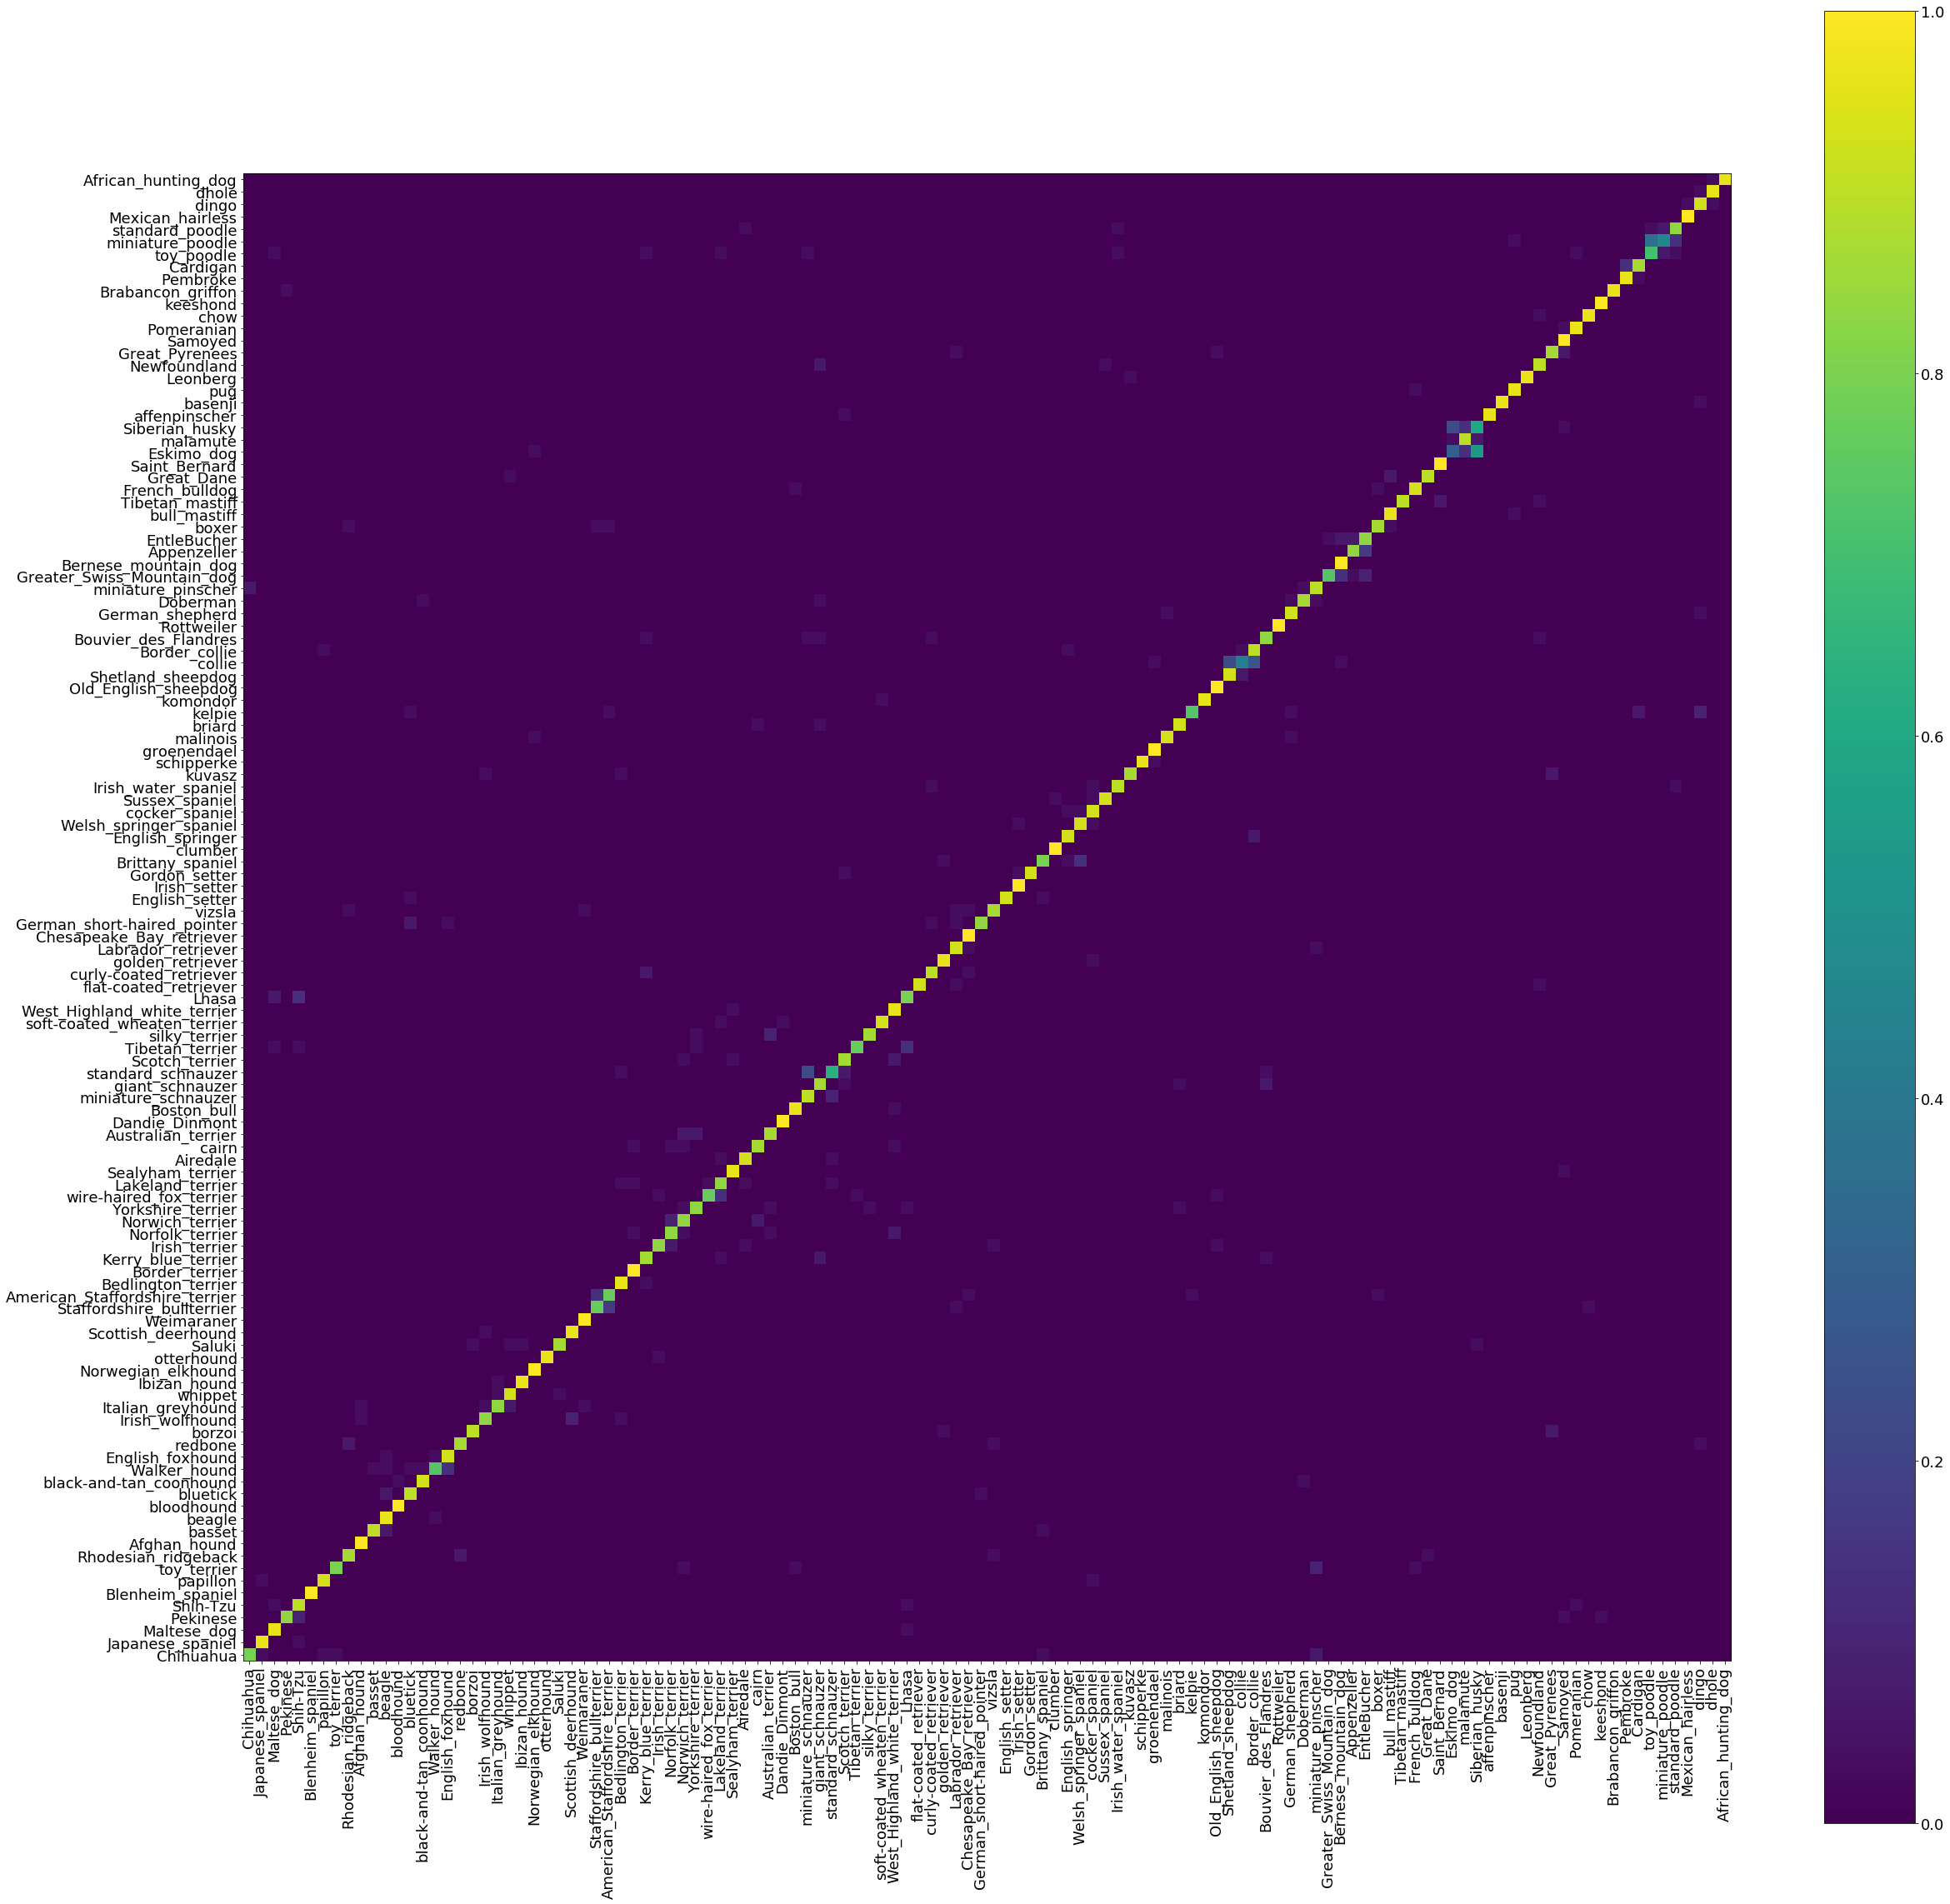

In [25]:
# Plotting the confusion map
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(40,40))
plt.xticks(range(120), class_names, rotation = 'vertical')
plt.yticks(range(120), class_names)
conf_mat = confusion_matrix(lst_labels, lst_preds, labels=None, sample_weight=None)/30
plt.imshow(conf_mat, cmap = 'viridis', origin = 'lower')
plt.colorbar()
plt.show()

In [26]:
# Statistics of the misclassified pairs
conf_matnodiag = conf_mat
# Removing the diagonal of our matrix (which are the well classified breeds) 
conf_matnodiag[range(120),range(120)]=0
c1, c2 = np.where(conf_matnodiag>.2)
print('The top misclassified pair of breeds are:')
for i, j in zip(c1,c2):
    print(class_names[i] +' -> '+ class_names[j] +' score =', conf_mat[i,j]*100 ,'%')

The top misclassified pair of breeds are:
standard_schnauzer -> miniature_schnauzer score = 23.3333333333 %
collie -> Shetland_sheepdog score = 23.3333333333 %
collie -> Border_collie score = 26.6666666667 %
Eskimo_dog -> Siberian_husky score = 53.3333333333 %
Siberian_husky -> Eskimo_dog score = 23.3333333333 %
miniature_poodle -> toy_poodle score = 36.6666666667 %
